In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.optimize import fsolve
import casadi as ca
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, LSTM, Dense


In [40]:
np.random.seed(42)
A1 = (2.6)*(10**-3)
Lc = 2
kv = 0.38
P1 = 4.5
P_out = 5
C = 479

timestep = 5
epochs = 750
units = 100
nData = 500

alphas = np.random.uniform(0.2,0.8, timestep*2)

def fun(variables, A1, Lc, kv, P1, P_out, C) :
    (x,y) = variables
    eqn_1 = (A1/Lc)* ((1.5 * P1) - y)
    eqn_2 = (C**2)/2 * (x - alphas[0] * kv * np.sqrt(y - P_out))
    return [eqn_1, eqn_2]


result = fsolve(fun, (0, 10), args = (A1, Lc, kv, P1, P_out, C)) 

init_m = result[0]
init_p = result[1]
interval = [np.linspace(i * nData, (i + 1) * nData, nData) for i in range(timestep*2)]
x = ca.MX.sym('x', 2)
alpha = ca.MX.sym('alpha', 1)
massFlowrate = []
PlenumPressure = []
alpha_values = []
RNN_train = []
RNN_trainFut = []
RNN_test = []

for i in range(0,timestep*2): 
    alpha_values.append([np.full(nData, alphas[i])])

    rhs = ca.vertcat((A1/Lc)*((1.5 * P1) - x[1]), (C**2)/2 * (x[0] - alpha * kv * np.sqrt(x[1] - P_out)))
    ode = {'x' : x, 'ode' : rhs, 'p' : alpha }

    F = ca.integrator('F','idas', ode, interval[i][0], interval[i])
    
    sol = F(x0 = [init_m, init_p], p = alphas[i])

    xf_values = np.array(sol["xf"])

    aux1, aux2 = xf_values
    massFlowrate.append(aux1)
    PlenumPressure.append(aux2)
    init_m = aux1[-1]
    init_p = aux2[-1]

    if i < timestep:
        RNN_train.append([aux1, aux2, np.full(nData,alphas[i])])
        RNN_trainFut.append([aux1, aux2, np.full(nData,alphas[i+1])])
    else:
        RNN_test.append([aux1, aux2, np.full(nData,alphas[i])])


<Figure size 640x480 with 0 Axes>

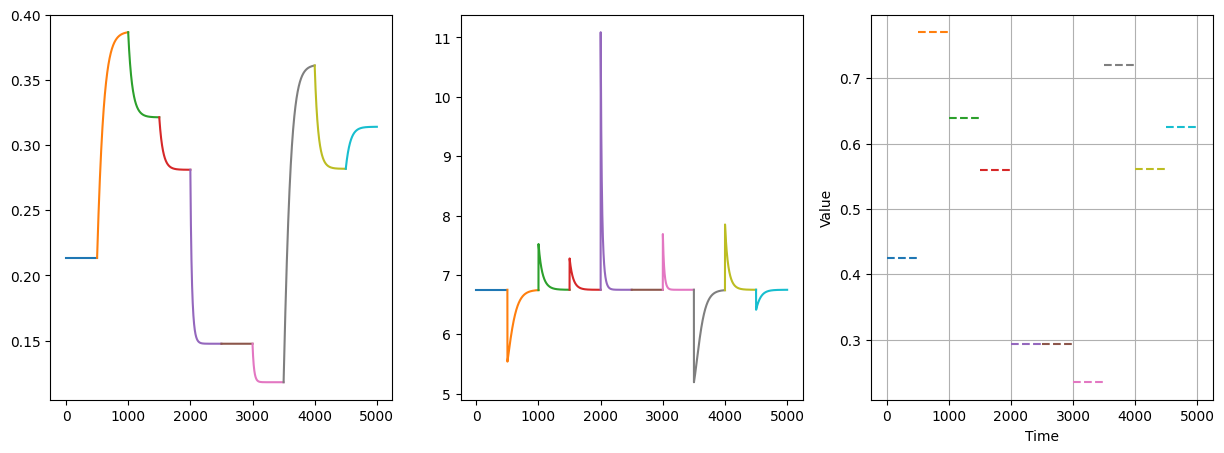

In [41]:
plt.figure("mass flow rate x time")

fig, axs = plt.subplots(1, 3, figsize=(15, 5), )

for i in range(0,timestep*2):
    axs[0].plot(interval[i], np.squeeze(massFlowrate[i]), label='x0(t)')
    axs[1].plot(interval[i], np.squeeze(PlenumPressure[i]),label='x0(t)')
    axs[2].plot(interval[i], np.squeeze(alpha_values[i]), linestyle='--')
plt.grid(True)
plt.xlabel('Time')  
plt.ylabel('Value')

plt.show()


In [49]:
RNN_train = np.array(RNN_train)
RNN_trainFut = np.array(RNN_trainFut)
RNN_test = np.array(RNN_test)

X_train = []
y_trainM = []
y_trainP = []
x_test = []


for i in range(len(RNN_train[0][0])):
    X_train.append(RNN_train[:,:,i])
    x_test.append(RNN_test[:,:,i])
    # RESOLVER J PARA SABER QUE È O ULTIMO ALPHA

    if i == (len(RNN_train[0][0]) - 1):
        if j == (len(alphas)-timestep-1):
            y_trainM.append(RNN_test[:, :1, 0])
            y_trainP.append(RNN_test[:, 1:2, 0])
        else:
            y_trainM.append(RNN_trainFut[:, :1, 0])
            y_trainP.append(RNN_trainFut[:, 1:2, 0])
    else:
        y_trainM.append(RNN_train[:,:1,i+1])
        y_trainP.append(RNN_train[:,1:2,i+1])


X_train = np.array(X_train)
X_train = X_train/np.max(X_train)

y_trainM = np.array(y_trainM)
y_trainM = y_trainM/np.max(y_trainM)

y_trainP = np.array(y_trainP)
y_trainP = y_trainP/np.max(y_trainP)

x_test = np.array(x_test)
x_testN = x_test/np.max(x_test)



[0.42472407 0.77042858 0.63919637 0.55919509 0.29361118]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [13]:
# Definindo a entrada
input_layer = Input(shape=(timestep, 3))  # 3 variáveis de entrada

# Camada RNN
rnn_output = LSTM(units, return_sequences=True)(input_layer)

# Saídas para cada variável de saída
output1 = Dense(1,activation='relu', name='Mass')(rnn_output)  # Primeira saída
output2 = Dense(1,activation='relu', name='Press')(rnn_output)  # Segunda saída

# Modelo
model = Model(inputs=input_layer, outputs=[output1, output2])

model.compile(optimizer='adam', 
              loss={'Mass': 'mse', 
                    'Press': 'mse'},
              metrics={'Mass': 'mse', 
                       'Press': 'mse'})

history = model.fit(X_train, [y_trainM, y_trainP], epochs=epochs, verbose = 0)


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 500
'y' sizes: 2000, 2000


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


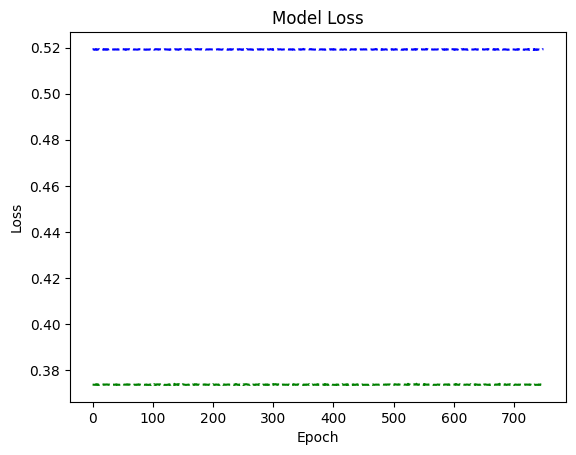

Text(0.5, 1.0, 'Plenum Pressure vs Time')

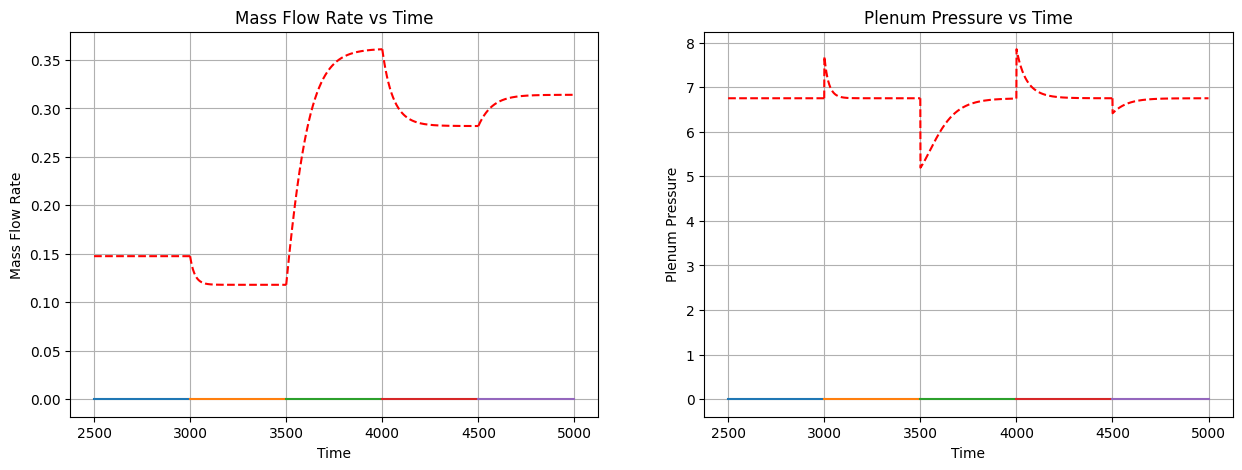

In [6]:
mass, pressure = np.array(model.predict(x_testN))
max_mass = np.max(x_test[:,:,0])
max_pressure = np.max(x_test[:,:,1])

# Plot the training loss
plt.plot(history.history['Mass_loss'], 'b--', label = 'Mass Loss')
plt.plot(history.history['Press_loss'], 'g--', label = 'Pressure Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Cria uma figura com subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5), )

# Gráfico da mass FlowRate vs. Tempo
for i in range(timestep, timestep*2):
    axs[0].plot(interval[i], np.squeeze(mass[:,i-timestep]* max_mass))
    axs[0].plot(interval[i], np.squeeze(massFlowrate[i]), 'r--')
    axs[1].plot(interval[i], np.squeeze(pressure[:,i-timestep]* max_pressure))
    axs[1].plot(interval[i], np.squeeze(PlenumPressure[i]), 'r--')
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Mass Flow Rate')
axs[0].set_title('Mass Flow Rate vs Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Plenum Pressure')
axs[1].set_title('Plenum Pressure vs Time')